In [1]:
from nbdev.showdoc import *

In [2]:
#default_exp core

In [2]:
#export
from fastai2.text.all import *

The data is seperated into two folders, `train` and `valid`.

In [2]:
ls data/en-100

train/  valid/


The issue is that all of the data, in each folder, lives in just a single file. We want to run the tokenization in parallel and as such it would be best to split the files.

In [39]:
#export
def split_file_into_chunks(path, num_chunks=24):
    txt = Path(path).read().split('\n')
    chunk_len = len(txt) // num_chunks
    
    for i in range(num_chunks):
        with open(Path(path).parent / f'{i}.txt', "w") as text_file:
            text_file.write('\n'.join(txt[i*chunk_len:(i+1)*chunk_len]))

In [4]:
# split_file_into_chunks('data/en-100/train/en.wiki.train.tokens')
# split_file_into_chunks('data/en-100/valid/en.wiki.valid.tokens')

In [5]:
# !rm data/en-100/train/*.txt
# !rm data/en-100/valid/*.txt

In [6]:
ls data/en-100/train

0.txt   13.txt  17.txt  20.txt  2.txt  6.txt  en.wiki.train.tokens
10.txt  14.txt  18.txt  21.txt  3.txt  7.txt
11.txt  15.txt  19.txt  22.txt  4.txt  8.txt
12.txt  16.txt  1.txt   23.txt  5.txt  9.txt


To tokenize the text, we can use the very handy `tokenize_folder` function.

In [7]:
# tokenize_folder('data/en-100/', folders=['train', 'valid'])

The tokenized text now lives in a new folder.

In [8]:
ls data/en-100_tok/

counter.pkl  models/  train/  valid/


To have control over the vocabulary our LM will use, we can use `make_vocab` 

In [3]:
vocab = make_vocab(pd.read_pickle('data/en-100_tok/counter.pkl'), max_vocab=4000)

In [4]:
# path = 'data/en-100_tok/'
# mult = 4
# bs = 80
# seq_len = 70

# lm = DataBlock(blocks=(TextBlock(get_tokenizer(), vocab=vocab, is_lm=True, seq_len=seq_len),),
#                 get_x=read_tokenized_file,
#                 get_items=partial(get_text_files, folders=['train', 'valid']),
#                 splitter=splitter)

# dbunch_lm = lm.databunch(path, path=path, bs=bs, seq_len=seq_len)

In [4]:
path = 'data/en-100_tok/'
mult = 4
bs = 80
seq_len = 70

lm = DataBlock(blocks=(TextBlock(vocab=vocab, is_lm=True),),
                get_x=read_tokenized_file,
                get_items=partial(get_text_files, folders=['train', 'valid']),
                splitter=FuncSplitter(lambda itm: itm.parent.name == 'valid'))

dbunch_lm = lm.databunch(path, path=path, bs=bs, seq_len=seq_len)

If we go for a vocab of 4k, how many unknowns will we get?

In [12]:
torch.mean((torch.cat([tup[0] for tup in dbunch_lm.valid_ds]) == 0).float())

tensor(0.1373)

This is stunning, the fact that just 4k tokens cover so much vocabulary! Since the initial intent is exploratory, a 4k vocab will be a great starting point. This should allow us to experiment with all of the architectures we have in our arsenal without worrying too much about memory footprint.

Let's start with training a basic architecture with a permutation matrix between the embeddings and the model. This setup will allow us to experiment whether the model will be able to learn the mapping of words to embeddings should we wipe it out. Also, what happens if we replace the English embeddings with embeddings from a different language? Is there enough structure in the embedding space for the LM to be able to map foreign language embeddings to their English counterparts?

We replace the encoder with our `PermuteEmgedding` layer. 

In [5]:
#export
class PermuteEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        self.p = nn.Parameter( torch.eye(self.num_embeddings) )
        self.p.requires_grad = False
        
        self.reset_parameters()
        
    def forward(self, words):
        return F.embedding(words, self.p @ self.weight)
    
    def reset_parameters(self): pass

Time to modify the `AWD_LSTM` architecture.

In [6]:
#export
class pAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
#         self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder = PermuteEmbedding(vocab_sz, emb_sz, padding_idx=pad_token)
    
#         self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
        self.encoder_dp = self.encoder # chosing to initally train without embedding dropout
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

Adding our architecture to `_model_meta` so that we can nicely interface with the `fastai v2` machinery.

In [7]:
#export
import fastai2
fastai2.text.models.core._model_meta[pAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [8]:
#export

# TODO: add gradient clipping of 0.12 at some point

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1150,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

In [9]:
learn = language_model_learner(
    dbunch_lm,
    pAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.1,
    metrics=[accuracy]
)

In [17]:
learn.fit_one_cycle(1, 5e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.904468,2.818111,0.426659,46:37


In [18]:
# learn.save('pLSTM_en')

In [10]:
learn.load('pLSTM_en')

In [44]:
learn.predict('The man', n_words=20)

"The man who tried to hit the Le Recording Company in Mount Stephen 's army near"

Now that we have a trained LM, let's wipe the mapping from words to embeddings and see if we can recover it.

We will freeze the model and only train the part mapping from word idx to embedding (or, in other words, performing a linear combination of embeddings and ideally assigning the largest weight to the correct embedding for a given word idx).

In [11]:
#export
import warnings

@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    self.model[0].encoder.p.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    self.model[0].encoder.p.requires_grad = False

In [12]:
learn.optimize_permutation()

In [13]:
learn.model[0].encoder.p.requires_grad

True

In [14]:
learn.model[0].encoder.weight.requires_grad

False

In [4]:
#export
def aza_loss(learn, input=None, target=None, scaling_factor=5/2000, debug=False):
    p = learn.model[0].encoder.p
    sums_to_one = (1-p.abs().sum(dim=0)).abs().sum() + (1-p.abs().sum(dim=1)).abs().sum()
    the_model = CrossEntropyLossFlat()(input, target)
    if debug: return sums_to_one, the_model
    else:     return scaling_factor * sums_to_one + (1 - scaling_factor) * the_model

In [24]:
learn.model[0].encoder.p

Parameter containing:
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0', requires_grad=True)

In [25]:
preds, targs = learn.get_preds()

In [26]:
aza_loss(learn, preds, targs)

tensor(2.8107, device='cuda:0', grad_fn=<AddBackward0>)

In [27]:
nn.init.kaiming_normal_(learn.model[0].encoder.p)

Parameter containing:
tensor([[ 0.0051,  0.0193, -0.0052,  ..., -0.0437, -0.0082, -0.0039],
        [-0.0143,  0.0311,  0.0125,  ...,  0.0009, -0.0131, -0.0531],
        [ 0.0110, -0.0108,  0.0508,  ..., -0.0026,  0.0138, -0.0033],
        ...,
        [-0.0406,  0.0192,  0.0293,  ..., -0.0078, -0.0231, -0.0044],
        [-0.0192, -0.0023, -0.0092,  ..., -0.0520, -0.0204,  0.0116],
        [ 0.0316, -0.0025,  0.0039,  ..., -0.0014, -0.0006,  0.0467]],
       device='cuda:0', requires_grad=True)

In [28]:
preds, targs = learn.get_preds()

In [30]:
aza_loss(learn, preds, targs, debug=True)

(tensor(564637.8750, device='cuda:0', grad_fn=<AddBackward0>), tensor(6.2451))

In [31]:
learn.loss_func = lambda preds, targs: aza_loss(learn, preds, targs)

In [30]:
learn.fit_one_cycle(1, 1e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,3.020772,2.977226,0.403813,40:20


In [31]:
# learn.save('pLSTM_en_permute_embeddings')

In [11]:
learn.load('pLSTM_en_permute_embeddings')

In [13]:
#export
@patch_to(LMLearner)
def hitInTopN(self, n=1, how_many=None):
    data = self.model[0].encoder.p.data.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [14]:
learn.hitInTopN(1, 100), learn.hitInTopN(5, 100)

(0.9899999499320984, 1.0)

In [15]:
acc1 = [(x, learn.hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, learn.hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, learn.hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, learn.hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, learn.hitInTopN(10, x)) for x in range(50,1500,200)]

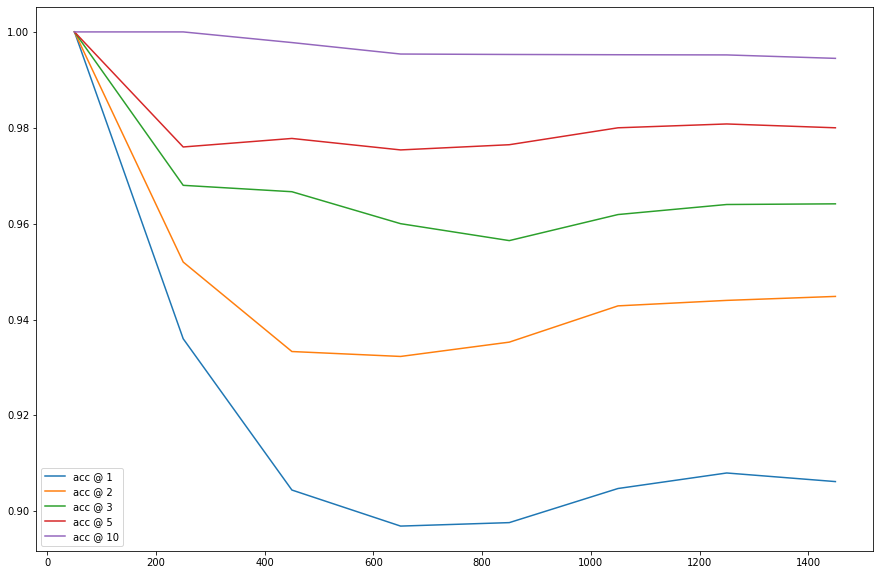

In [16]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [17]:
#export
@patch_to(LMLearner)
def print_synonyms(self, start_idx, n):
    data = self.model[0].encoder.p.data.argsort(descending=True)[:, :5]
    print('actual word\t\tpredictions\n')
    for i in range(start_idx, start_idx+n):
        print(f'{self.dbunch.vocab[i]}\t\t{[self.dbunch.vocab[idx] for idx in data[i]]}')

In [18]:
learn.print_synonyms(60, 20)

actual word		predictions

two		['two', 'three', 'four', 'few', 'five']
or		['or', 'nor', '&', 'and', '/']
have		['have', 've', 'has', 'shall', 'will']
who		['who', 'whom', 'whose', 'he', 'you']
new		['new', 'great', 'greater', 'larger', 'los']
been		['been', 'become', 'remained', 'being', 'come']
has		['has', 've', 'have', 'will', 'shall']
@,@		['@,@', '×', '<', 'xxrep', 'per']
she		['she', 'madonna', 'actress', 'neither', 'none']
when		['when', 'shortly', 'here', 'meanwhile', 'although']
time		['time', 'moment', 'way', 'times', 'reason']
during		['during', 'throughout', 'shortly', 'within', 'after']
other		['other', 'different', 'others', 'older', 'smaller']
would		['would', 'might', 'could', 'should', "'ll"]
into		['into', 'onto', 'across', 'toward', 'towards']
all		['all', 'every', 'any', 'both', 'those']
i		['i', 'we', 'doesn', '[', '<']
more		['more', 'less', 'relatively', 'very', 'much']
0		['0', '600', '500', '700', '400']
while		['while', 'whilst', 'whereas', 'although', 'short

In [19]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_train_LM_en.ipynb.
Converted 01_train_LM_es.ipynb.
Converted 99_index.ipynb.
Converted language_play_v9.ipynb.
Converted language_play_v9_mixer.ipynb.
Converted language_play_v9_mixer_softmax.ipynb.
